# Digital Watermarking chống lại Geometry Attacks dùng DWT + SIFT

## Mục đích

Bài thực nghiệm này nhằm nghiên cứu và cài đặt một hệ thống digital watermarking có khả năng chống chịu trước các tấn công hình học (geometric attacks) như xoay, co giãn, dịch chuyển, cắt xén, và biến đổi affine. Mục tiêu chính là bảo vệ bản quyền hình ảnh số thông qua việc nhúng và trích xuất watermark một cách bền vững.

## Phương pháp thực hiện

Phương pháp đề xuất kết hợp hai kỹ thuật chính:

1. **Discrete Wavelet Transform (DWT)**: Sử dụng để nhúng watermark vào miền tần số của ảnh, cụ thể là subband LL của kênh Y trong không gian màu YCbCr. Việc nhúng trong miền DWT giúp tăng tính bền vững và ít ảnh hưởng đến chất lượng ảnh gốc.

2. **Scale-Invariant Feature Transform (SIFT)**: Áp dụng để thực hiện căn chỉnh (registration) ảnh đã bị tấn công về trạng thái ban đầu trước khi tiến hành trích xuất watermark. SIFT có khả năng tìm và khớp các điểm đặc trưng bất biến với các biến đổi hình học.

Quy trình hoạt động gồm hai giai đoạn:
- **Giai đoạn nhúng**: Watermark được nhúng vào subband LL của DWT trong kênh Y
- **Giai đoạn trích xuất**: Sử dụng SIFT để căn chỉnh ảnh bị tấn công, sau đó áp dụng DWT nghịch để trích xuất watermark

Hiệu quả của phương pháp được đánh giá thông qua các chỉ số PSNR (chất lượng ảnh sau nhúng), NCC và BER (độ chính xác trích xuất sau tấn công), đồng thời so sánh với các phương pháp baseline: DWT đơn thuần và SIFT-only.


## 1. Thiết lập môi trường và import thư viện

Import các thư viện cần thiết cho xử lý ảnh, watermarking và đánh giá kết quả.


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pywt
import skimage
from skimage import filters, transform, util, color, exposure, metrics
from scipy import ndimage
from typing import Tuple, List, Dict
import random
import math
import os
from pathlib import Path
from dataclasses import dataclass

# Datasets
try:
    import kagglehub
    print("✓ KaggleHub available")
except Exception as e:
    kagglehub = None
    print("⚠ KaggleHub not available. Install with: pip install kagglehub")

# SIFT availability check
try:
    sift = cv2.SIFT_create()
    print("✓ SIFT available")
except AttributeError:
    raise ImportError("❌ OpenCV SIFT unavailable. Install with: pip install opencv-contrib-python")

print("✓ All libraries imported successfully")


✓ KaggleHub available
✓ SIFT available
✓ All libraries imported successfully


## 2. Cấu hình thử nghiệm

Thiết lập các tham số cho watermarking và thử nghiệm.


In [45]:
@dataclass
class Config:
    # Dataset settings
    dataset_id: str = "prasunroy/natural-images"  # Kaggle dataset ID
    max_images: int = 10  # Số lượng ảnh tối đa để test
    
    # Image processing
    image_size: Tuple[int, int] = (512, 512)
    watermark_size: Tuple[int, int] = (64, 64)
    
    # DWT parameters
    dwt_wavelet: str = "db2"
    dwt_level: int = 1
    alpha_dwt: float = 5.0  # Cường độ nhúng DWT
    
    # SIFT parameters  
    alpha_sift: float = 5.0  # Cường độ nhúng SIFT-only
    
    # Experiment settings
    random_seed: int = 42
    show_visual_comparison: bool = True  # Hiển thị so sánh trực quan

cfg = Config()
random.seed(cfg.random_seed)
np.random.seed(cfg.random_seed)

print("Cấu hình thử nghiệm:")
print(f"  📁 Dataset: {cfg.dataset_id}")
print(f"  🖼️  Max images: {cfg.max_images}")
print(f"  📏 Image size: {cfg.image_size}")
print(f"  🔷 Watermark size: {cfg.watermark_size}")
print(f"  🌊 DWT: {cfg.dwt_wavelet}, level {cfg.dwt_level}, alpha {cfg.alpha_dwt}")
print(f"  🎯 SIFT alpha: {cfg.alpha_sift}")


Cấu hình thử nghiệm:
  📁 Dataset: prasunroy/natural-images
  🖼️  Max images: 10
  📏 Image size: (512, 512)
  🔷 Watermark size: (64, 64)
  🌊 DWT: db2, level 1, alpha 5.0
  🎯 SIFT alpha: 5.0


## 3. Tải dataset từ KaggleHub

Tải và chuẩn bị dữ liệu ảnh từ Kaggle dataset.


In [46]:
def download_dataset():
    """Tải dataset từ KaggleHub"""
    if kagglehub is None:
        print("❌ KaggleHub không khả dụng, sử dụng ảnh mẫu từ skimage")
        return None
    
    try:
        print(f"📥 Đang tải dataset: {cfg.dataset_id}")
        path = kagglehub.dataset_download(cfg.dataset_id)
        print(f"✓ Dataset đã tải về: {path}")
        return path
    except Exception as e:
        print(f"❌ Lỗi tải dataset: {e}")
        return None

def collect_images_from_path(dataset_path, max_images=10):
    """Thu thập đường dẫn ảnh từ thư mục dataset"""
    if dataset_path is None:
        return []
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_paths = []
    
    dataset_path = Path(dataset_path)
    for ext in image_extensions:
        image_paths.extend(list(dataset_path.rglob(f"*{ext}")))
        image_paths.extend(list(dataset_path.rglob(f"*{ext.upper()}")))
    
    # Lấy ngẫu nhiên max_images ảnh
    if len(image_paths) > max_images:
        np.random.shuffle(image_paths)
        image_paths = image_paths[:max_images]
    
    return [str(p) for p in image_paths]

# Tải dataset
dataset_path = download_dataset()
image_paths = collect_images_from_path(dataset_path, cfg.max_images)

print(f"📊 Tìm thấy {len(image_paths)} ảnh để thử nghiệm")
if image_paths:
    print("📂 Một số ảnh mẫu:")
    for i, path in enumerate(image_paths[:5]):
        print(f"   {i+1}. {Path(path).name}")
    if len(image_paths) > 5:
        print(f"   ... và {len(image_paths)-5} ảnh khác")


📥 Đang tải dataset: prasunroy/natural-images


100%|██████████| 342M/342M [00:18<00:00, 19.1MB/s] 

Extracting files...


✓ Dataset đã tải về: C:\Users\ADMIN\.cache\kagglehub\datasets\prasunroy\natural-images\versions\1
📊 Tìm thấy 10 ảnh để thử nghiệm
📂 Một số ảnh mẫu:
   1. car_0411.jpg
   2. car_0625.jpg
   3. flower_0452.jpg
   4. flower_0634.jpg
   5. airplane_0272.jpg
   ... và 5 ảnh khác


## 4. Xử lý và tạo dữ liệu thử nghiệm

Tiền xử lý ảnh và tạo watermark nhị phân.


In [47]:
SAMPLE_IMAGES = [
    ("camera", skimage.data.camera()),
    ("astronaut", skimage.data.astronaut()),
    ("coins", skimage.data.coins()),
]

def read_and_preprocess(img, size: Tuple[int, int]):
    """Đọc và tiền xử lý ảnh"""
    if isinstance(img, str):
        bgr = cv2.imread(img, cv2.IMREAD_COLOR)
        if bgr is None:
            raise ValueError(f"Không thể đọc ảnh: {img}")
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
        
    # Resize và normalize
    rgb = transform.resize(rgb, size, anti_aliasing=True)
    if rgb.ndim == 2:
        rgb = np.stack([rgb, rgb, rgb], axis=-1)
    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)

def generate_binary_watermark(size: Tuple[int, int], seed: int = 42) -> np.ndarray:
    """Tạo watermark nhị phân ngẫu nhiên"""
    rng = np.random.default_rng(seed)
    wm = rng.integers(0, 2, size=size, dtype=np.uint8)
    return wm

# Chuẩn bị dữ liệu ảnh
images = []
if image_paths:
    print("📷 Đang xử lý ảnh từ dataset...")
    for i, path in enumerate(image_paths):
        try:
            img = read_and_preprocess(path, cfg.image_size)
            name = Path(path).stem
            images.append((name, img))
            print(f"  ✓ {i+1}/{len(image_paths)}: {name}")
        except Exception as e:
            print(f"  ❌ Lỗi xử lý {Path(path).name}: {e}")
else:
    print("📷 Sử dụng ảnh mẫu từ skimage...")
    for name, arr in SAMPLE_IMAGES:
        img = read_and_preprocess(arr, cfg.image_size)
        images.append((name, img))
        print(f"  ✓ {name}")

# Tạo watermark
watermark = generate_binary_watermark(cfg.watermark_size, seed=cfg.random_seed)

print(f"\n✅ Đã chuẩn bị:")
print(f"   🖼️  {len(images)} ảnh test")
print(f"   🔷 Watermark {watermark.shape} (tỷ lệ bit 1: {watermark.mean():.2f})")


📷 Đang xử lý ảnh từ dataset...
  ✓ 1/10: car_0411
  ✓ 2/10: car_0625
  ✓ 3/10: flower_0452
  ✓ 4/10: flower_0634
  ✓ 5/10: airplane_0272
  ✓ 6/10: airplane_0428
  ✓ 7/10: motorbike_0674
  ✓ 8/10: fruit_0032
  ✓ 9/10: motorbike_0485
  ✓ 10/10: airplane_0275

✅ Đã chuẩn bị:
   🖼️  10 ảnh test
   🔷 Watermark (64, 64) (tỷ lệ bit 1: 0.50)


## 5. Hàm tiện ích và đo lường

Các hàm chuyển đổi màu sắc, đo PSNR, NCC, BER.


In [49]:
# Metrics and helpers

def to_gray_uint8(img_rgb: np.ndarray) -> np.ndarray:
    if img_rgb.ndim == 2:
        g = img_rgb
    else:
        g = color.rgb2gray(img_rgb)
    g = np.clip(g, 0, 1)
    return (g * 255).astype(np.uint8)


def to_ycbcr(img_rgb: np.ndarray) -> np.ndarray:
    rgbf = img_rgb.astype(np.float32) / 255.0
    ycbcr = cv2.cvtColor(rgbf, cv2.COLOR_RGB2YCrCb)
    return ycbcr


def from_ycbcr(ycbcr: np.ndarray) -> np.ndarray:
    rgbf = cv2.cvtColor(ycbcr, cv2.COLOR_YCrCb2RGB)
    rgb = np.clip(rgbf * 255.0, 0, 255).astype(np.uint8)
    return rgb


def psnr(img1: np.ndarray, img2: np.ndarray) -> float:
    return float(metrics.peak_signal_noise_ratio(img1, img2, data_range=255))


def ncc(a: np.ndarray, b: np.ndarray) -> float:
    # Treat input as binary {0,1} arrays of same shape
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    am = a - a.mean()
    bm = b - b.mean()
    denom = (np.linalg.norm(am) * np.linalg.norm(bm))
    if denom == 0:
        return 0.0
    return float((am * bm).sum() / denom)


def ber(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(np.uint8)
    b = b.astype(np.uint8)
    diff = (a ^ b).sum()
    return float(diff) / a.size


def resize_to(arr: np.ndarray, size: Tuple[int, int]) -> np.ndarray:
    out = transform.resize(arr, size, anti_aliasing=True, preserve_range=True)
    return out.astype(arr.dtype)


In [50]:
# DWT embed/extract (embed on Y channel LL subband)

def dwt_embed(host_rgb: np.ndarray, watermark_bin: np.ndarray, alpha: float, wavelet: str, level: int) -> Tuple[np.ndarray, Dict]:
    ycbcr = to_ycbcr(host_rgb)
    Y = ycbcr[..., 0]
    coeffs = pywt.wavedec2(Y, wavelet=wavelet, level=level)
    LL, details = coeffs[0], coeffs[1:]

    wm = resize_to(watermark_bin.astype(np.float32), LL.shape)
    LL_w = LL + alpha * (wm - 0.5)  # embed +/- around mean

    coeffs_w = [LL_w] + details
    Y_w = pywt.waverec2(coeffs_w, wavelet=wavelet)
    Y_w = resize_to(Y_w, Y.shape)

    ycbcr_w = ycbcr.copy()
    ycbcr_w[..., 0] = np.clip(Y_w, 0, 1)
    watermarked = from_ycbcr(ycbcr_w)

    meta = {
        "LL_shape": LL.shape,
    }
    return watermarked, meta


def dwt_extract(attacked_rgb: np.ndarray, meta: Dict, alpha: float, wavelet: str, level: int, watermark_shape: Tuple[int, int]) -> np.ndarray:
    ycbcr = to_ycbcr(attacked_rgb)
    Y = ycbcr[..., 0]
    coeffs = pywt.wavedec2(Y, wavelet=wavelet, level=level)
    LL = coeffs[0]
    # Decision by sign relative to 0.5 after inverse embedding model
    # We cannot access original LL; use threshold at 0.5 by reversing embedding model approx
    # w* ~ (LL - mean(LL) > 0) after normalization. Simpler: use sigmoid around 0.5 embedding.
    # Here we assume embedding as LL + alpha*(wm-0.5). So estimate wm ~ (LL - median(LL) > 0)
    thresh = np.median(LL)
    w_est = (LL - thresh) > 0
    w_est = w_est.astype(np.uint8)
    w_est = resize_to(w_est, watermark_shape).astype(np.uint8)
    return w_est


In [51]:
# SIFT helpers: keypoints, matching, homography, warp
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=64)
flann = cv2.FlannBasedMatcher(index_params, search_params)


def detect_and_describe(gray_uint8: np.ndarray):
    kp, des = sift.detectAndCompute(gray_uint8, None)
    return kp, des


def match_descriptors(des1, des2, ratio=0.75):
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good


def estimate_homography(src_gray: np.ndarray, dst_gray: np.ndarray):
    kp1, des1 = detect_and_describe(src_gray)
    kp2, des2 = detect_and_describe(dst_gray)
    if des1 is None or des2 is None:
        return None, None, None, None
    good = match_descriptors(des1, des2)
    if len(good) < 8:
        return None, None, None, None
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    return H, kp1, kp2, good


def warp_to_reference(attacked_rgb: np.ndarray, ref_rgb: np.ndarray) -> np.ndarray:
    src = to_gray_uint8(ref_rgb)
    dst = to_gray_uint8(attacked_rgb)
    H, kp1, kp2, good = estimate_homography(src, dst)
    h, w = src.shape
    if H is None:
        return attacked_rgb
    warped = cv2.warpPerspective(attacked_rgb, H, (w, h))
    return warped


In [52]:
# SIFT-only embed/extract (simple additive on Y channel w/o DWT)

def sift_spatial_embed(host_rgb: np.ndarray, watermark_bin: np.ndarray, alpha: float) -> Tuple[np.ndarray, Dict]:
    ycbcr = to_ycbcr(host_rgb)
    Y = ycbcr[..., 0]
    wm = resize_to(watermark_bin.astype(np.float32), Y.shape)
    Y_w = np.clip(Y + alpha * (wm - 0.5) / 2.0, 0, 1)  # weaker for fairness
    ycbcr_w = ycbcr.copy()
    ycbcr_w[..., 0] = Y_w
    return from_ycbcr(ycbcr_w), {}


def sift_spatial_extract(attacked_rgb: np.ndarray, ref_rgb: np.ndarray, watermark_shape: Tuple[int,int]) -> np.ndarray:
    # register attacked to ref using SIFT, then threshold Y
    warped = warp_to_reference(attacked_rgb, ref_rgb)
    ycbcr = to_ycbcr(warped)
    Y = ycbcr[..., 0]
    thresh = np.median(Y)
    w_est = (Y - thresh) > 0
    w_est = w_est.astype(np.uint8)
    w_est = resize_to(w_est, watermark_shape).astype(np.uint8)
    return w_est


In [53]:
# Geometric attacks

def attack_rotate(img_rgb: np.ndarray, angle_deg: float) -> np.ndarray:
    h, w = img_rgb.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    return cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)


def attack_scale(img_rgb: np.ndarray, scale: float) -> np.ndarray:
    h, w = img_rgb.shape[:2]
    out = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LINEAR)
    out = cv2.resize(out, (w, h), interpolation=cv2.INTER_LINEAR)
    return out


def attack_translate(img_rgb: np.ndarray, tx: int, ty: int) -> np.ndarray:
    h, w = img_rgb.shape[:2]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)


def attack_crop(img_rgb: np.ndarray, crop_ratio: float = 0.2) -> np.ndarray:
    h, w = img_rgb.shape[:2]
    ch, cw = int(h*(1-crop_ratio)), int(w*(1-crop_ratio))
    y0 = (h - ch) // 2
    x0 = (w - cw) // 2
    cropped = img_rgb[y0:y0+ch, x0:x0+cw]
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)


def attack_affine_random(img_rgb: np.ndarray, max_offset: int = 30) -> np.ndarray:
    h, w = img_rgb.shape[:2]
    pts1 = np.float32([[0,0],[w-1,0],[0,h-1]])
    pts2 = pts1 + np.float32([[random.randint(-max_offset, max_offset), random.randint(-max_offset, max_offset)] for _ in range(3)])
    M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)


## 8. Hàm hiển thị và so sánh trực quan

Hiển thị ảnh gốc, ảnh đã nhúng watermark, ảnh sau tấn công và ảnh đã phục hồi.


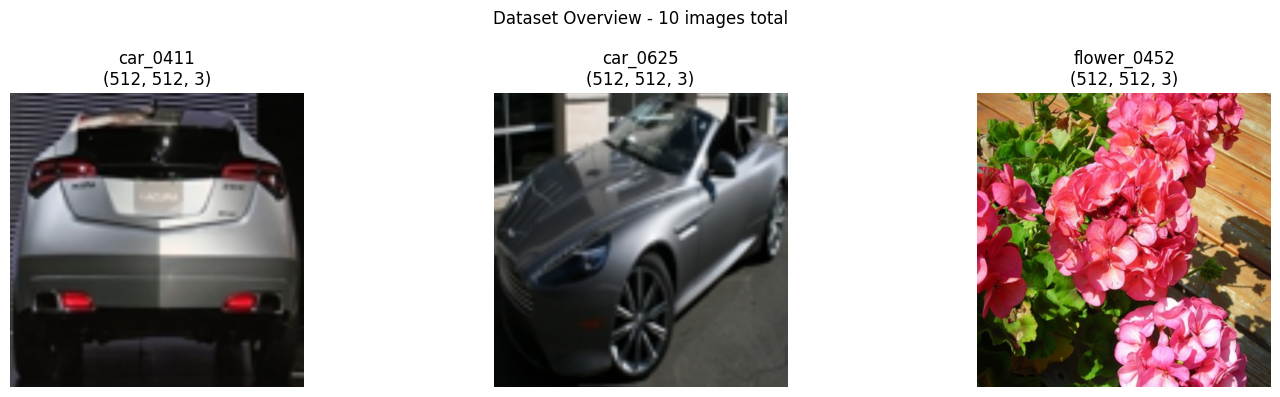

In [54]:
def show_watermark_comparison(original_wm, extracted_wms, methods, title="Watermark Comparison"):
    """Hiển thị so sánh watermark gốc và các watermark được trích xuất"""
    n_methods = len(methods)
    fig, axes = plt.subplots(1, n_methods + 1, figsize=(3*(n_methods+1), 3))
    
    if n_methods == 0:
        axes = [axes]
    
    # Watermark gốc
    axes[0].imshow(original_wm, cmap='gray')
    axes[0].set_title('Original Watermark')
    axes[0].axis('off')
    
    # Watermark trích xuất
    for i, (method, wm) in enumerate(zip(methods, extracted_wms)):
        axes[i+1].imshow(wm, cmap='gray')
        ncc_val = ncc(original_wm, wm)
        ber_val = ber(original_wm, wm)
        axes[i+1].set_title(f'{method}\nNCC:{ncc_val:.3f}, BER:{ber_val:.3f}')
        axes[i+1].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_image_pipeline(host, watermarked, attacked, recovered, attack_name, method_name, psnr_val):
    """Hiển thị pipeline xử lý ảnh: gốc → nhúng → tấn công → phục hồi"""
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(host)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(watermarked)
    axes[1].set_title(f'Watermarked\nPSNR: {psnr_val:.2f} dB')
    axes[1].axis('off')
    
    axes[2].imshow(attacked)
    axes[2].set_title(f'After Attack\n({attack_name})')
    axes[2].axis('off')
    
    axes[3].imshow(recovered)
    axes[3].set_title(f'After Recovery\n({method_name})')
    axes[3].axis('off')
    
    plt.suptitle(f'Image Processing Pipeline - {method_name}')
    plt.tight_layout()
    plt.show()

def show_overview_comparison(images_sample, max_show=3):
    """Hiển thị tổng quan các ảnh trong dataset"""
    n_show = min(max_show, len(images_sample))
    fig, axes = plt.subplots(1, n_show, figsize=(5*n_show, 4))
    
    if n_show == 1:
        axes = [axes]
    
    for i, (name, img) in enumerate(images_sample[:n_show]):
        axes[i].imshow(img)
        axes[i].set_title(f'{name}\n{img.shape}')
        axes[i].axis('off')
    
    plt.suptitle(f'Dataset Overview - {len(images_sample)} images total')
    plt.tight_layout()
    plt.show()

# Hiển thị tổng quan dataset
if cfg.show_visual_comparison and images:
    show_overview_comparison(images, max_show=3)


In [55]:
# Baseline DWT-only extract without SIFT registration

def dwt_only_extract(attacked_rgb: np.ndarray, watermark_shape: Tuple[int,int]) -> np.ndarray:
    # simply run dwt_extract without any registration; use same params
    return dwt_extract(attacked_rgb, meta={}, alpha=cfg.alpha_dwt, wavelet=cfg.dwt_wavelet, level=cfg.dwt_level, watermark_shape=watermark_shape)


In [56]:
from collections import defaultdict

# Định nghĩa các tấn công hình học
ATTACKS = [
    ("rotate_-30", lambda im: attack_rotate(im, -30)),
    ("rotate_+30", lambda im: attack_rotate(im, 30)),
    ("scale_0.5", lambda im: attack_scale(im, 0.5)),
    ("scale_2.0", lambda im: attack_scale(im, 2.0)),
    ("translate_10_10", lambda im: attack_translate(im, 10, 10)),
    ("translate_20_-10", lambda im: attack_translate(im, 20, -10)),
    ("crop_0.2", lambda im: attack_crop(im, 0.2)),
    ("affine_rand", lambda im: attack_affine_random(im, 30)),
]

results_rows = []
visual_examples = []  # Lưu ví dụ để hiển thị

print("🚀 Bắt đầu thực nghiệm watermarking...")
print(f"📊 Sẽ test {len(images)} ảnh với {len(ATTACKS)} loại tấn công")

for img_idx, (name, img) in enumerate(images):
    print(f"\n📷 Xử lý ảnh {img_idx+1}/{len(images)}: {name}")
    
    host = img
    # Nhúng DWT
    wm_img_dwt, meta_dwt = dwt_embed(host, watermark, cfg.alpha_dwt, cfg.dwt_wavelet, cfg.dwt_level)
    psnr_dwt = psnr(host, wm_img_dwt)
    
    # Nhúng SIFT-only
    wm_img_sift, meta_sift = sift_spatial_embed(host, watermark, cfg.alpha_sift)
    psnr_sift = psnr(host, wm_img_sift)
    
    print(f"  ✓ Nhúng watermark: PSNR_DWT={psnr_dwt:.2f}dB, PSNR_SIFT={psnr_sift:.2f}dB")

    # Đánh giá các tấn công
    for att_idx, (att_name, att_fn) in enumerate(ATTACKS):
        print(f"    🎯 Tấn công {att_name}...")
        
        att_dwt = att_fn(wm_img_dwt)
        att_sift = att_fn(wm_img_sift)

        # Proposed: SIFT registration + DWT extract
        reg_dwt = warp_to_reference(att_dwt, host)
        w_rec_proposed = dwt_extract(reg_dwt, meta_dwt, cfg.alpha_dwt, cfg.dwt_wavelet, cfg.dwt_level, cfg.watermark_size)

        # Baselines
        w_rec_dwt_only = dwt_only_extract(att_dwt, cfg.watermark_size)
        w_rec_sift_only = sift_spatial_extract(att_sift, host, cfg.watermark_size)

        # Tính toán metrics
        row = {
            "image": name,
            "attack": att_name,
            "psnr_dwt": psnr_dwt,
            "psnr_sift": psnr_sift,
            "ncc_proposed": ncc(watermark, w_rec_proposed),
            "ber_proposed": ber(watermark, w_rec_proposed),
            "ncc_dwt_only": ncc(watermark, w_rec_dwt_only),
            "ber_dwt_only": ber(watermark, w_rec_dwt_only),
            "ncc_sift_only": ncc(watermark, w_rec_sift_only),
            "ber_sift_only": ber(watermark, w_rec_sift_only),
        }
        results_rows.append(row)
        
        # Lưu ví dụ để hiển thị (chỉ ảnh đầu tiên và một số tấn công)
        if img_idx == 0 and att_idx < 3 and cfg.show_visual_comparison:
            visual_examples.append({
                'name': name,
                'attack': att_name,
                'host': host,
                'watermarked': wm_img_dwt,
                'attacked': att_dwt,
                'recovered': reg_dwt,
                'psnr': psnr_dwt,
                'watermarks': [w_rec_proposed, w_rec_dwt_only, w_rec_sift_only],
                'methods': ['Proposed (DWT+SIFT)', 'DWT-only', 'SIFT-only']
            })

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results_rows)

print(f"\n✅ Hoàn thành thực nghiệm!")
print(f"📈 Tổng số kết quả: {len(results_df)} (từ {len(images)} ảnh × {len(ATTACKS)} tấn công)")
print(f"📊 Xem trước kết quả:")
print(results_df.head())


🚀 Bắt đầu thực nghiệm watermarking...
📊 Sẽ test 10 ảnh với 8 loại tấn công

📷 Xử lý ảnh 1/10: car_0411
  ✓ Nhúng watermark: PSNR_DWT=6.48dB, PSNR_SIFT=6.49dB
    🎯 Tấn công rotate_-30...
    🎯 Tấn công rotate_+30...
    🎯 Tấn công scale_0.5...
    🎯 Tấn công scale_2.0...
    🎯 Tấn công translate_10_10...
    🎯 Tấn công translate_20_-10...
    🎯 Tấn công crop_0.2...
    🎯 Tấn công affine_rand...

📷 Xử lý ảnh 2/10: car_0625
  ✓ Nhúng watermark: PSNR_DWT=6.47dB, PSNR_SIFT=6.48dB
    🎯 Tấn công rotate_-30...
    🎯 Tấn công rotate_+30...
    🎯 Tấn công scale_0.5...
    🎯 Tấn công scale_2.0...
    🎯 Tấn công translate_10_10...
    🎯 Tấn công translate_20_-10...
    🎯 Tấn công crop_0.2...
    🎯 Tấn công affine_rand...

📷 Xử lý ảnh 3/10: flower_0452
  ✓ Nhúng watermark: PSNR_DWT=7.58dB, PSNR_SIFT=7.59dB
    🎯 Tấn công rotate_-30...
    🎯 Tấn công rotate_+30...
    🎯 Tấn công scale_0.5...
    🎯 Tấn công scale_2.0...
    🎯 Tấn công translate_10_10...
    🎯 Tấn công translate_20_-10...
    🎯 Tấn 

In [57]:
# Tổng hợp kết quả theo loại tấn công
summary = results_df.groupby("attack").agg({
    "psnr_dwt":"mean",
    "psnr_sift":"mean", 
    "ncc_proposed":"mean",
    "ber_proposed":"mean",
    "ncc_dwt_only":"mean",
    "ber_dwt_only":"mean",
    "ncc_sift_only":"mean",
    "ber_sift_only":"mean",
}).round(3).reset_index()

print("📊 Bảng tổng hợp kết quả (trung bình theo loại tấn công):")
print(summary)

# Thống kê tổng quan
print(f"\n📈 Thống kê tổng quan:")
print(f"  🎯 PSNR trung bình sau nhúng:")
print(f"    • DWT: {summary['psnr_dwt'].mean():.2f} dB")
print(f"    • SIFT-only: {summary['psnr_sift'].mean():.2f} dB")

print(f"  🔍 NCC trung bình trên tất cả tấn công:")
print(f"    • Proposed (DWT+SIFT): {summary['ncc_proposed'].mean():.3f}")
print(f"    • DWT-only: {summary['ncc_dwt_only'].mean():.3f}")
print(f"    • SIFT-only: {summary['ncc_sift_only'].mean():.3f}")

print(f"  ❌ BER trung bình trên tất cả tấn công:")
print(f"    • Proposed (DWT+SIFT): {summary['ber_proposed'].mean():.3f}")
print(f"    • DWT-only: {summary['ber_dwt_only'].mean():.3f}")
print(f"    • SIFT-only: {summary['ber_sift_only'].mean():.3f}")


📊 Bảng tổng hợp kết quả (trung bình theo loại tấn công):
             attack  psnr_dwt  psnr_sift  ncc_proposed  ber_proposed  \
0       affine_rand     6.966      6.984           0.0         0.496   
1          crop_0.2     6.966      6.984           0.0         0.496   
2        rotate_+30     6.966      6.984           0.0         0.496   
3        rotate_-30     6.966      6.984           0.0         0.496   
4         scale_0.5     6.966      6.984           0.0         0.496   
5         scale_2.0     6.966      6.984           0.0         0.496   
6   translate_10_10     6.966      6.984           0.0         0.496   
7  translate_20_-10     6.966      6.984           0.0         0.496   

   ncc_dwt_only  ber_dwt_only  ncc_sift_only  ber_sift_only  
0           0.0         0.496          0.007          0.496  
1           0.0         0.496         -0.003          0.496  
2           0.0         0.496         -0.000          0.496  
3           0.0         0.496         -0.000  

## 9. Chạy thực nghiệm với hiển thị trực quan

Thực hiện watermarking trên tất cả ảnh với hiển thị kết quả từng bước.


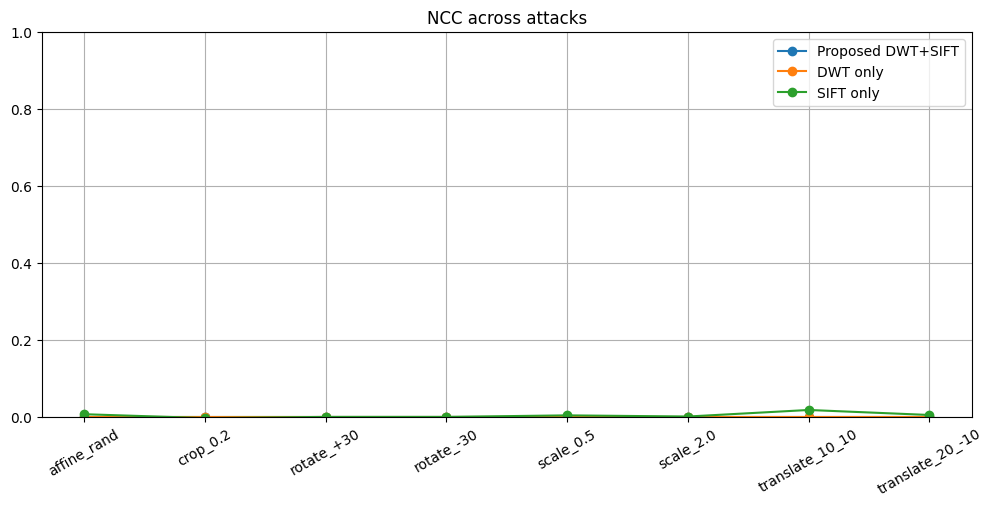

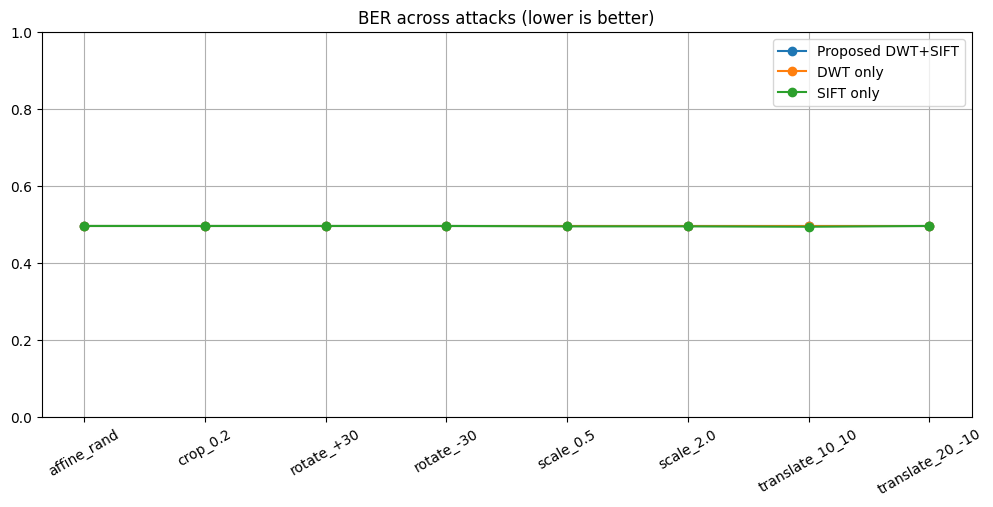

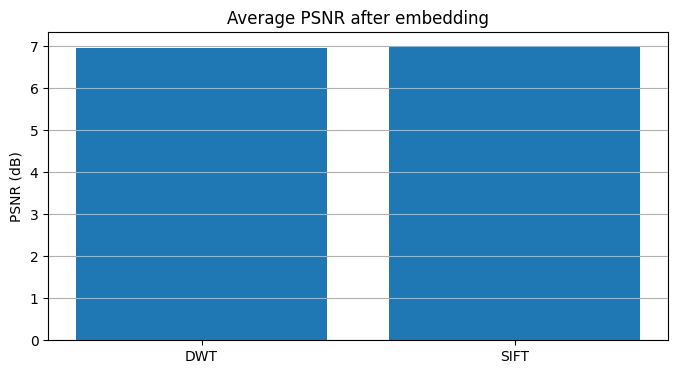

In [58]:
# Plot comparisons
plt.figure(figsize=(12,5))
ax = plt.gca()
for col, label in [("ncc_proposed","Proposed DWT+SIFT"),("ncc_dwt_only","DWT only"),("ncc_sift_only","SIFT only")]:
    ax.plot(summary["attack"], summary[col], marker='o', label=label)
ax.set_title("NCC across attacks")
ax.set_ylim(0,1)
ax.legend(); plt.xticks(rotation=30); plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
ax = plt.gca()
for col, label in [("ber_proposed","Proposed DWT+SIFT"),("ber_dwt_only","DWT only"),("ber_sift_only","SIFT only")]:
    ax.plot(summary["attack"], summary[col], marker='o', label=label)
ax.set_title("BER across attacks (lower is better)")
ax.set_ylim(0,1)
ax.legend(); plt.xticks(rotation=30); plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
ax = plt.gca()
ax.bar(["DWT","SIFT"],[summary["psnr_dwt"].mean(), summary["psnr_sift"].mean()])
ax.set_title("Average PSNR after embedding")
ax.set_ylabel("PSNR (dB)"); plt.grid(axis='y')
plt.show()



🎨 Hiển thị ví dụ trực quan...

📸 Ảnh: car_0411 - Tấn công: rotate_-30


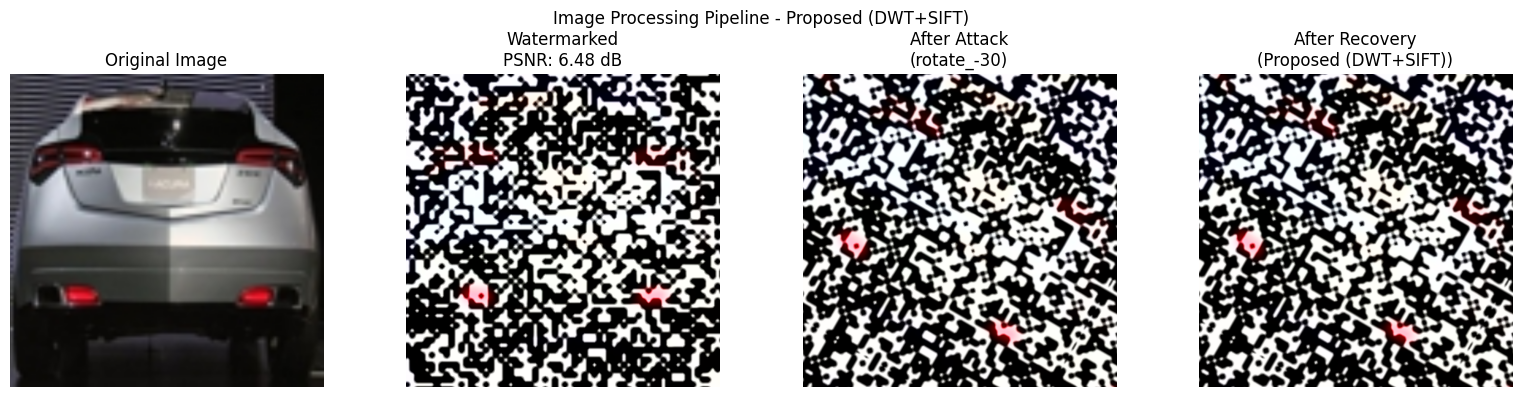

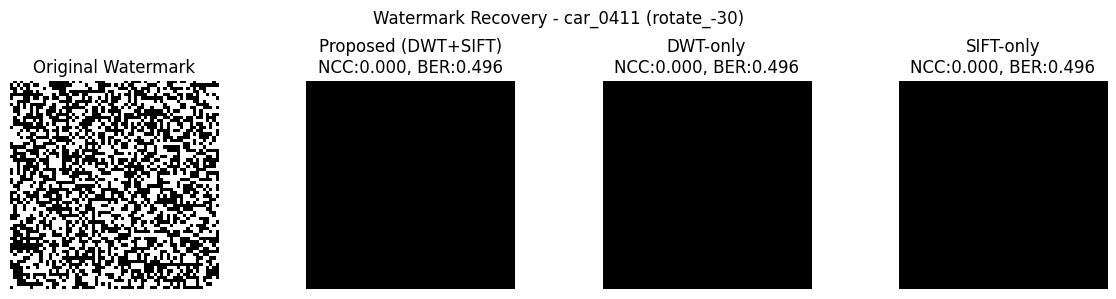


📸 Ảnh: car_0411 - Tấn công: rotate_+30


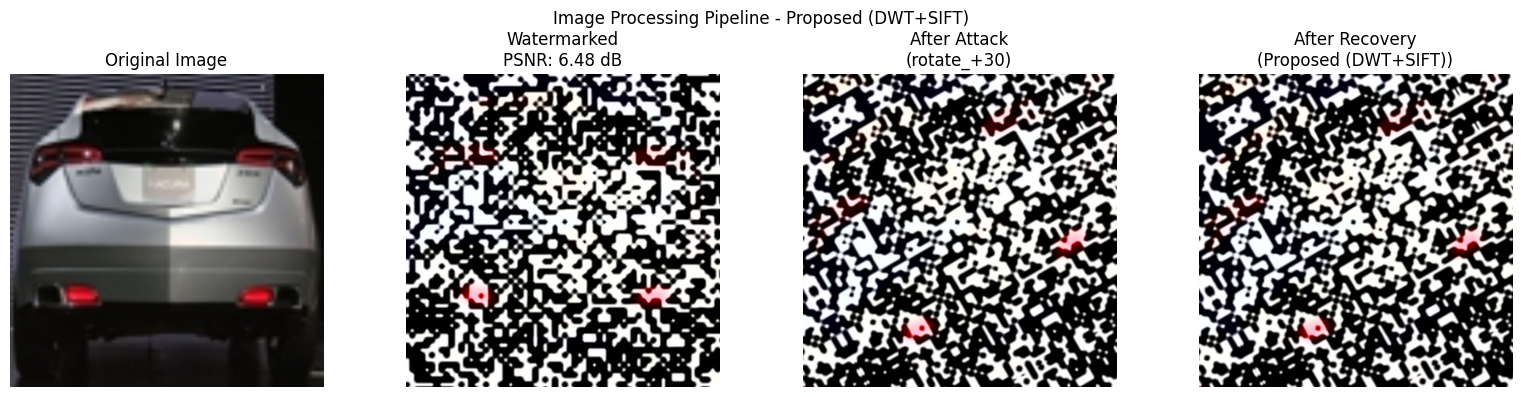

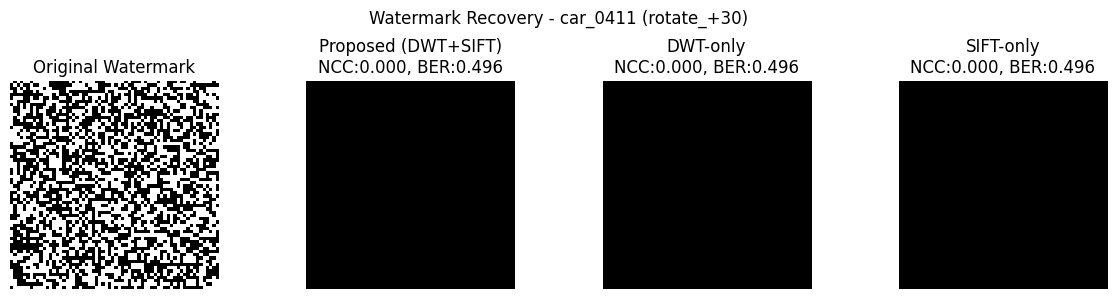


📸 Ảnh: car_0411 - Tấn công: scale_0.5


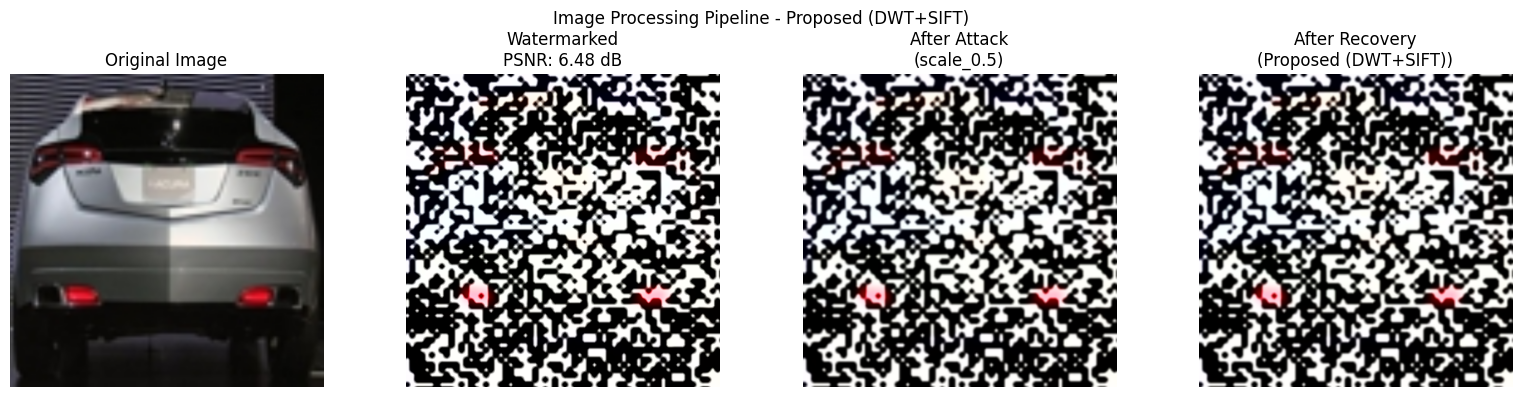

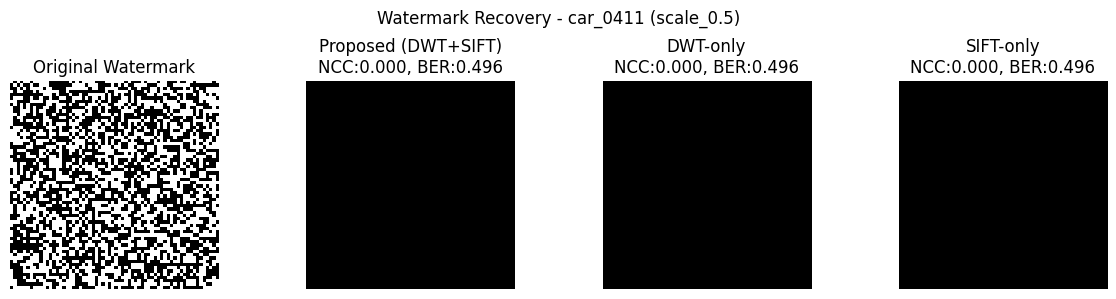

In [59]:
# Hiển thị các ví dụ trực quan
if cfg.show_visual_comparison and visual_examples:
    print("\n🎨 Hiển thị ví dụ trực quan...")
    
    for example in visual_examples:
        print(f"\n📸 Ảnh: {example['name']} - Tấn công: {example['attack']}")
        
        # Hiển thị pipeline xử lý ảnh
        show_image_pipeline(
            example['host'], 
            example['watermarked'], 
            example['attacked'], 
            example['recovered'],
            example['attack'],
            "Proposed (DWT+SIFT)",
            example['psnr']
        )
        
        # Hiển thị so sánh watermark
        show_watermark_comparison(
            watermark,
            example['watermarks'],
            example['methods'],
            f"Watermark Recovery - {example['name']} ({example['attack']})"
        )


## 10. Tổng hợp và phân tích kết quả

Phân tích hiệu suất của các phương pháp trên từng loại tấn công.


## 11. Biểu đồ so sánh và đánh giá

Trực quan hóa kết quả thông qua các biểu đồ so sánh.


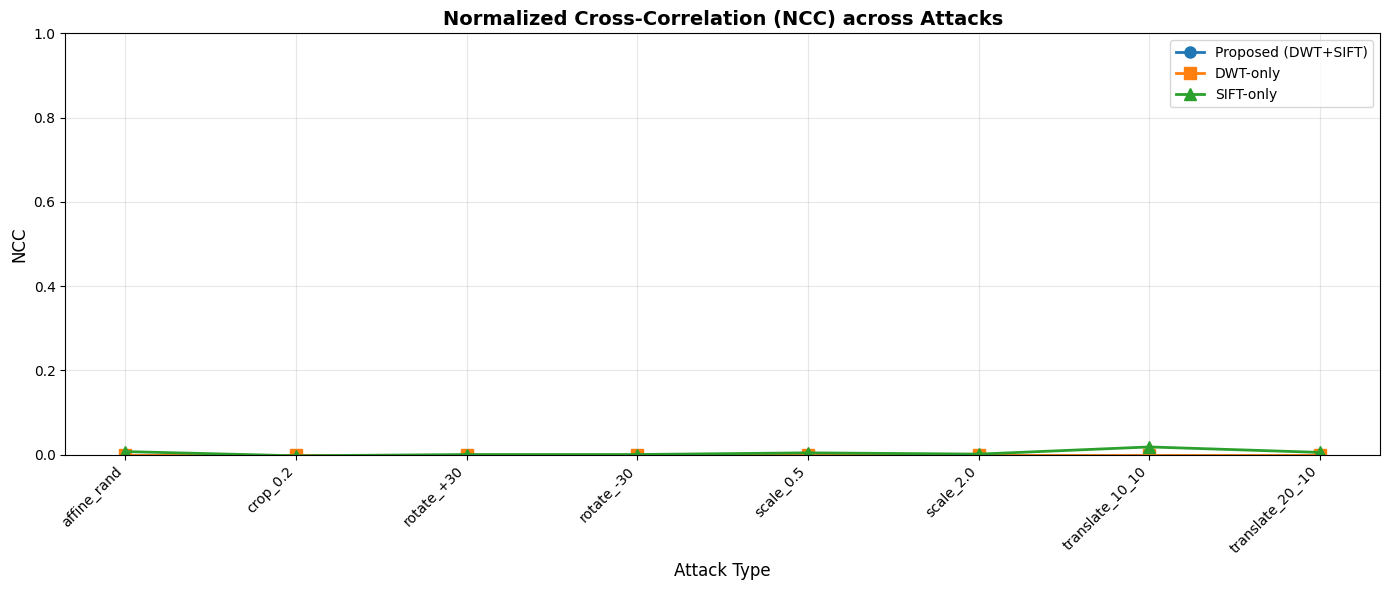

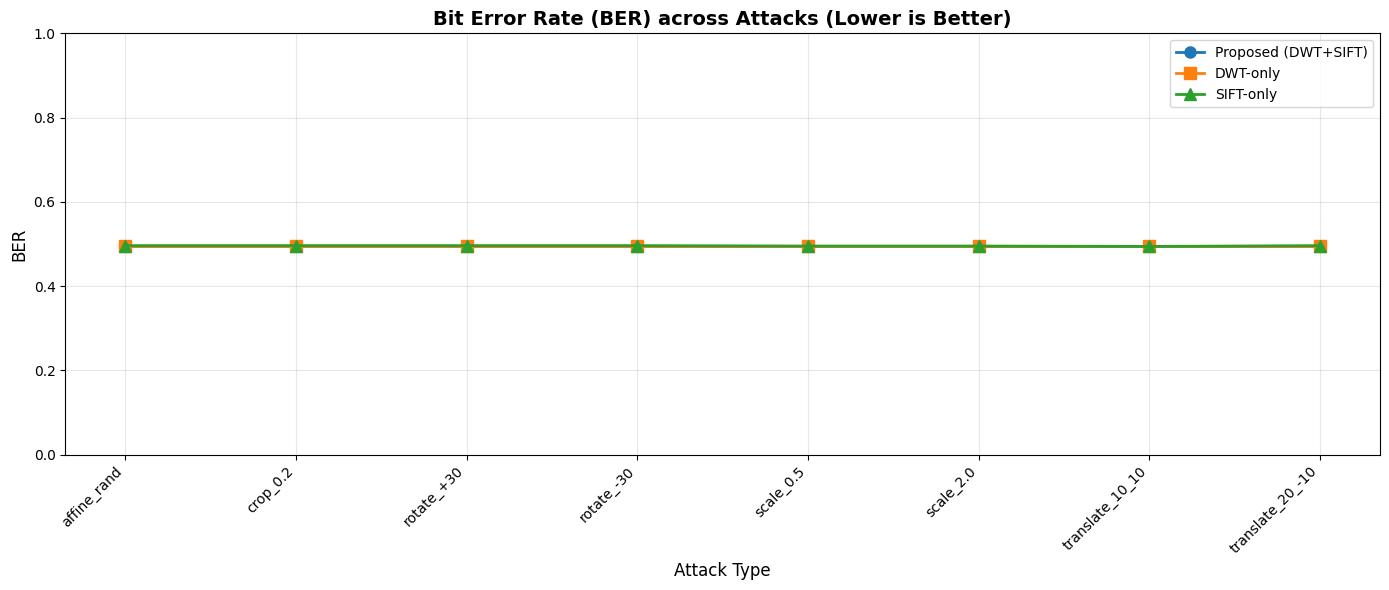

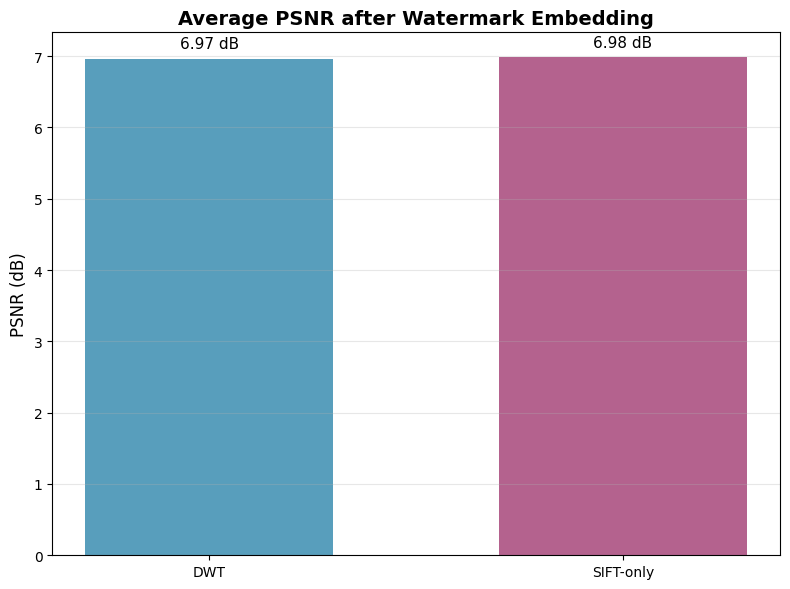

In [61]:
# Vẽ các biểu đồ so sánh
plt.style.use('default')

# 1. Biểu đồ NCC theo loại tấn công
plt.figure(figsize=(14,6))
ax = plt.gca()
for col, label, marker in [("ncc_proposed", "Proposed (DWT+SIFT)", "o"), 
                          ("ncc_dwt_only", "DWT-only", "s"), 
                          ("ncc_sift_only", "SIFT-only", "^")]:
    ax.plot(summary["attack"], summary[col], marker=marker, label=label, linewidth=2, markersize=8)

ax.set_title("Normalized Cross-Correlation (NCC) across Attacks", fontsize=14, fontweight='bold')
ax.set_xlabel("Attack Type", fontsize=12)
ax.set_ylabel("NCC", fontsize=12)
ax.set_ylim(0, 1)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Biểu đồ BER theo loại tấn công  
plt.figure(figsize=(14,6))
ax = plt.gca()
for col, label, marker in [("ber_proposed", "Proposed (DWT+SIFT)", "o"), 
                          ("ber_dwt_only", "DWT-only", "s"), 
                          ("ber_sift_only", "SIFT-only", "^")]:
    ax.plot(summary["attack"], summary[col], marker=marker, label=label, linewidth=2, markersize=8)

ax.set_title("Bit Error Rate (BER) across Attacks (Lower is Better)", fontsize=14, fontweight='bold')
ax.set_xlabel("Attack Type", fontsize=12)
ax.set_ylabel("BER", fontsize=12)
ax.set_ylim(0, 1)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Biểu đồ PSNR trung bình
plt.figure(figsize=(8,6))
ax = plt.gca()
methods = ["DWT", "SIFT-only"]
psnr_values = [summary["psnr_dwt"].mean(), summary["psnr_sift"].mean()]
bars = ax.bar(methods, psnr_values, color=['#2E86AB', '#A23B72'], alpha=0.8, width=0.6)

ax.set_title("Average PSNR after Watermark Embedding", fontsize=14, fontweight='bold')
ax.set_ylabel("PSNR (dB)", fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Thêm giá trị lên các cột
for bar, value in zip(bars, psnr_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{value:.2f} dB', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()